In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
def process_csv(directory):
    
    X_data = []
    y_data = []
    labels = {}
    label_counter = 0

    for dirpath, _, filenames in os.walk(directory):
    
        # Filter out CSV files
        csv_files = [filename for filename in filenames if filename.endswith('.csv')]

        if csv_files:
            # Proceed only if CSV files are found in the current directory
            # Create the output directory if it doesn't exist
            path_components = os.path.split(dirpath)
            output_head = path_components[0] + "_ltsm"
            # Indicate progress
            print(f"{path_components[1]} start")
            labels[path_components[1]] = label_counter
            print(f"Processing action: {path_components[1]} -> Label {label_counter} ...")
            
            output_directory = os.path.join(output_head, path_components[1])
            # os.makedirs(output_directory, exist_ok=True)
            
            for csv_file in csv_files:
                # Construct the full path to the CSV file
                csv_file_path = os.path.join(dirpath, csv_file)
                
                # Construct the output path
                output_file = os.path.join(output_directory, csv_file)
                
                # Load the matrix from the CSV file
                matrix = pd.read_csv(csv_file_path, header=None) 
                matrix = matrix.values.astype(float)
    
                # Normalize data
                scaler = MinMaxScaler()
                scaled_matrix = scaler.fit_transform(matrix)
                
                X_data.append(scaled_matrix)
                y_data.append(label_counter)
                
                
            # Indicate progress
            print(f"Action: {path_components[1]} -> Label {label_counter} done!")  
            label_counter += 1
    
    X_padded = pad_sequences(X_data, padding='post', dtype='float32')
    y_array = np.array(y_data)

    return X_padded, y_array, labels

folder_path = r"C:\Users\New Asus\Documents\FIT4701_2025_Sem1\resources\SHD-HAR-Dataset\SHD-HAR-Dataset-main\amplitude\front\micro"

X_all, y_all, label_map = process_csv(folder_path)

print("Data shape:", X_all.shape)
print("Labels shape:", y_all.shape)
print("Label map:", label_map)       

clap start
Processing action: clap -> Label 0 ...
Action: clap -> Label 0 done!
punching start
Processing action: punching -> Label 1 ...
Action: punching -> Label 1 done!
pushpull start
Processing action: pushpull -> Label 2 ...
Action: pushpull -> Label 2 done!
rubhand start
Processing action: rubhand -> Label 3 ...
Action: rubhand -> Label 3 done!
waving start
Processing action: waving -> Label 4 ...
Action: waving -> Label 4 done!
Data shape: (6094, 427, 166)
Labels shape: (6094,)
Label map: {'clap': 0, 'punching': 1, 'pushpull': 2, 'rubhand': 3, 'waving': 4}


In [5]:

total_csv = 0
for dirpath, _, filenames in os.walk(folder_path):
    csv_count = len([f for f in filenames if f.endswith(".csv")])
    print(f"{os.path.basename(dirpath)}: {csv_count} CSVs")
    total_csv += csv_count

print("Total CSVs found:", total_csv)

micro: 0 CSVs
clap: 1210 CSVs
punching: 1218 CSVs
pushpull: 1216 CSVs
rubhand: 1240 CSVs
waving: 1210 CSVs
Total CSVs found: 6094


In [6]:
# 6001 = total sequences (samples)
# 428 = time steps
# 166 = features per time step

# LTSM expected input = (batch_size, time_steps, features)

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# One-hot encode labels for softmax
num_classes = len(label_map)
y_all_cat = to_categorical(y_all, num_classes=num_classes)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all_cat, test_size=0.2, random_state=42)


model = Sequential()
# ignore timesteps with 0
model.add(Masking(mask_value=0., input_shape=(X_all.shape[1], X_all.shape[2])))
model.add(LSTM(128, activation = 'tanh', recurrent_activation='sigmoid', return_sequences=False))
# reduce overfitting
model.add(Dropout(0.5))
# dense hidden layer
model.add(Dense(64, activation='relu'))
# classification  layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model with 20% for validation
with tf.device('/CPU:0'):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 427, 166)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               151040    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 159,621
Trainable params: 159,621
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
153/153 [==============================

In [9]:
import numpy as np
print(np.isnan(X_train).any(), np.isinf(X_train).any())

False False


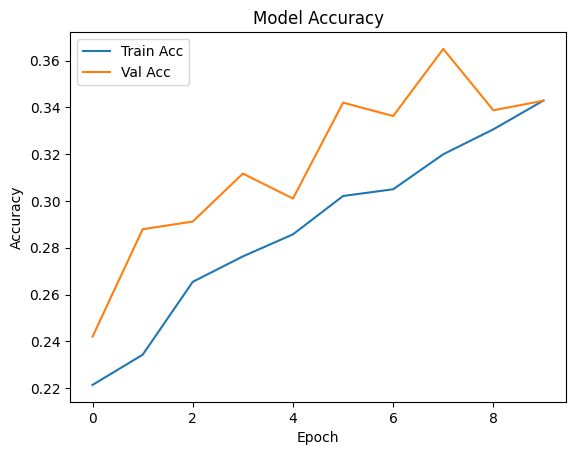

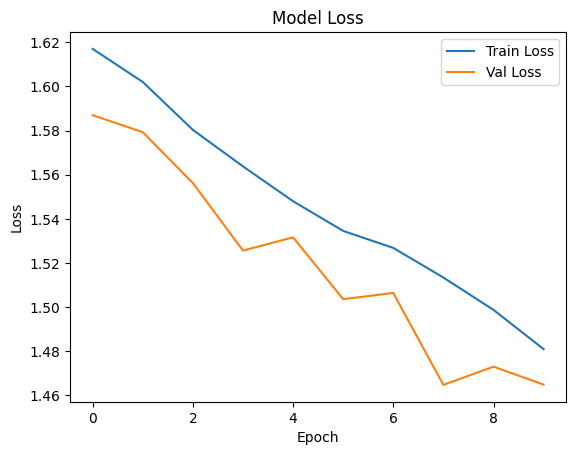

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [11]:
with tf.device('/CPU:0'):
    loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

39/39 [==============================] - 5s 120ms/step - loss: 1.4649 - accuracy: 0.3429
Test Accuracy: 0.3429
